# Quantifying the World
### Case Study 3
### Anish Bhandari


In [4]:
import os
import email
import pandas as pd
from collections import Counter

# List to store the email content, path, content types, and labels
raw_data = []
skipped_files = []
types = Counter()

# Path to base directory containing spam/ham folders
base_dir = r"C:\Users\bhand\OneDrive\Desktop\Quantifying the World\Case Studies\Case Study 3 - Classification NB"

# Traversing through directories to read files and extract raw data
for root, dirs, files in os.walk(base_dir):
    for f in files:
        path = os.path.join(root, f)
        
        # Skip non-email files like notebooks, pptx or others
        if f.endswith("ipynb") or f.endswith("pptx"):
            continue
        
        # Open the email file and read its content
        try:
            with open(path, 'r', encoding='latin-1') as file_point:
                msg = email.message_from_file(file_point)
                content_type = msg.get_content_type()
                types[content_type] += 1

                email_body = None

                # Extract email content based on its type
                if msg.is_multipart():
                    # If it's a multipart message, extract payload parts
                    for part in msg.walk():
                        if part.get_content_type() == 'text/plain':
                            email_body = part.get_payload(decode=True).decode('latin-1').replace("\n", " ")
                            break
                        elif part.get_content_type() == 'text/html':
                            email_body = part.get_payload(decode=True).decode('latin-1').replace("\n", " ")
                else:
                    # If not multipart, get the content directly
                    email_body = msg.get_payload(decode=True).decode('latin-1').replace("\n", " ")

                if email_body:
                    # Collect raw data including email path, content, content type, and label
                    label = 1 if "spam" in path else 0  # 1 for spam, 0 for ham
                    raw_data.append((path, email_body, content_type, label))
                else:
                    skipped_files.append((path, "No email body found"))

        except Exception as e:
            # Log skipped files due to reading issues
            skipped_files.append((path, str(e)))

#  DataFrame from the raw data
raw_df = pd.DataFrame(raw_data, columns=["Path", "Content", "Content_Type", "Label"])

# Save the DataFrame to csv to check contents
raw_df.to_csv("raw_email_data_with_content.csv", index=False)

# head
print(raw_df.head())

# Different content types encountered
print("Content Types Distribution:", types)

# Print details of skipped files, if any
if skipped_files:
    print(f"Skipped {len(skipped_files)} files.")
    for file, reason in skipped_files[:5]:  # Display up to 5 skipped files
        print(f"Skipped {file}: {reason}")


                                                Path  \
0  C:\Users\bhand\OneDrive\Desktop\Quantifying th...   
1  C:\Users\bhand\OneDrive\Desktop\Quantifying th...   
2  C:\Users\bhand\OneDrive\Desktop\Quantifying th...   
3  C:\Users\bhand\OneDrive\Desktop\Quantifying th...   
4  C:\Users\bhand\OneDrive\Desktop\Quantifying th...   

                                             Content Content_Type  Label  
0      Date:        Wed, 21 Aug 2002 10:54:46 -05...   text/plain      0  
1  Martin A posted: Tassos Papadopoulos, the Gree...   text/plain      0  
2  Man Threatens Explosion In Moscow   Thursday A...   text/plain      0  
3  Klez: The Virus That Won't Die   Already the m...   text/plain      0  
4  >  in adding cream to spaghetti carbonara, whi...   text/plain      0  
Content Types Distribution: Counter({'text/plain': 7413, 'text/html': 1193, 'multipart/alternative': 326, 'multipart/signed': 180, 'multipart/mixed': 179, 'multipart/related': 56, 'multipart/report': 5, 'text/plai

In [8]:
# Clean up text/html

# Function to clean HTML content
from bs4 import BeautifulSoup

def clean_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup.get_text(separator=" ").replace("\n", " ")

# Process the DataFrame and clean 'text/html' content
for idx, row in raw_df.iterrows():
    if row['Content_Type'] == 'text/html':  # Check if it's HTML content
        cleaned_text = clean_html(row['Content'])  # Clean the HTML content
        raw_df.at[idx, 'Content'] = cleaned_text  # Update the DataFrame with cleaned text

# Save the cleaned DataFrame
#raw_df.to_csv("cleaned_email_data.csv", index=False)

#print("HTML content cleaned and saved.")





In [9]:
# multipart/alternate

# Function to handle multipart/alternative
def extract_multipart_alternative(msg):
    for part in msg.get_payload():
        if part.get_content_type() == 'text/plain':  # We only want plain text
            return part.get_payload().replace("\n", " ")
    return None  # If no plain text is found

# Process the DataFrame and handle 'multipart/alternative' content
for idx, row in raw_df.iterrows():
    if row['Content_Type'] == 'multipart/alternative':  # Check if it's multipart/alternative
        try:
            msg = email.message_from_string(row['Content'])  # Parse email content
            if msg.is_multipart():
                plain_text = extract_multipart_alternative(msg)  # Extract plain text
                if plain_text:
                    raw_df.at[idx, 'Content'] = plain_text  # Update the DataFrame with extracted text
                else:
                    raw_df.at[idx, 'Content'] = None  # If no plain text, leave it as None
        except Exception as e:
            print(f"Error processing row {idx}: {e}")

# Save the cleaned DataFrame
#raw_df.to_csv("cleaned_email_data_multipart_alternative.csv", index=False)

#print("multipart/alternative content processed and saved.")


In [10]:
# multipart/mixed

# Function to handle multipart/mixed
def extract_multipart_mixed(msg):
    # Iterate through parts and look for 'text/plain' or 'text/html'
    for part in msg.get_payload():
        if part.get_content_type() == 'text/plain':  # Prefer plain text
            return part.get_payload().replace("\n", " ")
        elif part.get_content_type() == 'text/html':  # Fallback to HTML if no plain text
            return html_to_text(part.get_payload())  # Use our earlier HTML cleaner
    return None  # If no text content is found

# Process the DataFrame and handle 'multipart/mixed' content
for idx, row in raw_df.iterrows():
    if row['Content_Type'] == 'multipart/mixed':  # Check if it's multipart/mixed
        try:
            msg = email.message_from_string(row['Content'])  # Parse the email content
            if msg.is_multipart():
                text_content = extract_multipart_mixed(msg)  # Extract plain text or HTML content
                if text_content:
                    raw_df.at[idx, 'Content'] = text_content  # Update the DataFrame with extracted text
                else:
                    raw_df.at[idx, 'Content'] = None  # If no text found, mark as None
        except Exception as e:
            print(f"Error processing row {idx}: {e}")

# Save the cleaned DataFrame after processing multipart/mixed
#raw_df.to_csv("cleaned_email_data_multipart_mixed.csv", index=False)

#print("multipart/mixed content processed and saved.")


In [11]:
#  multipart/alternative

def extract_multipart_alternative(msg):
    # Iterate through parts and look for 'text/plain', fallback to 'text/html'
    for part in msg.get_payload():
        if part.get_content_type() == 'text/plain':  # Prefer plain text
            return part.get_payload().replace("\n", " ")
        elif part.get_content_type() == 'text/html':  # Fallback to HTML if no plain text
            return html_to_text(part.get_payload())  # Use earlier HTML cleaner
    return None  # If no text content is found

# Process the DataFrame and handle 'multipart/alternative' content
for idx, row in raw_df.iterrows():
    if row['Content_Type'] == 'multipart/alternative':  # Check if it's multipart/alternative
        try:
            msg = email.message_from_string(row['Content'])  # Parse the email content
            if msg.is_multipart():
                text_content = extract_multipart_alternative(msg)  # Extract plain text or HTML content
                if text_content:
                    raw_df.at[idx, 'Content'] = text_content  # Update the DataFrame with extracted text
                else:
                    raw_df.at[idx, 'Content'] = None  # If no text found, mark as None
        except Exception as e:
            print(f"Error processing row {idx}: {e}")

# Save the cleaned DataFrame after processing multipart/alternative
#raw_df.to_csv("cleaned_email_data_multipart_alternative.csv", index=False)

#print("multipart/alternative content processed and saved.")


In [12]:
#  'multipart/report' content
for idx, row in raw_df.iterrows():
    if row['Content_Type'] == 'multipart/report':  # Check if it's multipart/report
        try:
            # We can either skip these, or mark them with a placeholder
            raw_df.at[idx, 'Content'] = "[Email report - skipped]"  # Placeholder for multipart/report
        except Exception as e:
            print(f"Error processing row {idx}: {e}")

# Save the updated DataFrame after processing multipart/report
#raw_df.to_csv("cleaned_email_data_multipart_report.csv", index=False)

print("multipart/report content processed and saved.")


multipart/report content processed and saved.


In [13]:
#multipart/related

def handle_multipart_related(content):
    # Extract the main text from multipart/related
    for part in content.get_payload():
        if part.get_content_type() == 'text/plain':
            return part.get_payload().replace("\n", " ")
        elif part.get_content_type() == 'text/html':
            return html_to_text(part.get_payload())
    return None  # If no text part is found

# Now apply this logic to the 'multipart/related' entries in the dataframe
for idx, row in raw_df.iterrows():
    if row['Content_Type'] == 'multipart/related':  # Check if it's multipart/related content
        try:
            msg = email.message_from_string(row['Content'])
            cleaned_text = handle_multipart_related(msg)
            raw_df.at[idx, 'Content'] = cleaned_text  # Update DataFrame with cleaned text
        except Exception as e:
            print(f"Error processing multipart/related at {row['Path']}: {e}")

# Save the cleaned DataFrame
#raw_df.to_csv("cleaned_email_data.csv", index=False)


Error processing multipart/related at C:\Users\bhand\OneDrive\Desktop\Quantifying the World\Case Studies\Case Study 3 - Classification NB\easy_ham\00070.c62a036deb1de40aa32cabc761b0861c: 'str' object has no attribute 'get_content_type'
Error processing multipart/related at C:\Users\bhand\OneDrive\Desktop\Quantifying the World\Case Studies\Case Study 3 - Classification NB\easy_ham\00368.f86324a03e7ae7070cc40f302385f5d3: 'str' object has no attribute 'get_content_type'
Error processing multipart/related at C:\Users\bhand\OneDrive\Desktop\Quantifying the World\Case Studies\Case Study 3 - Classification NB\easy_ham\00704.e077ad131955ba1fa3b9ba7a68b78f62: 'str' object has no attribute 'get_content_type'
Error processing multipart/related at C:\Users\bhand\OneDrive\Desktop\Quantifying the World\Case Studies\Case Study 3 - Classification NB\easy_ham\0101.48557f7f38d947eab77aefc03d0520a3: 'str' object has no attribute 'get_content_type'
Error processing multipart/related at C:\Users\bhand\OneD

In [17]:
import re
import string
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Define cleaning functions
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

def to_lower(word):
    return word.lower()

def remove_number(word):
    return re.sub(r'\d+', '', word)

def remove_punctuation(word):
    return word.translate(str.maketrans('', '', string.punctuation))

def remove_whitespace(word):
    return word.strip()

def replace_newline(word):
    return word.replace('\n', ' ')

# Cleanup pipeline for text
def clean_up_pipeline(sentence):
    if sentence is None:  # Check for NoneType
        return ""
    cleaning_utils = [remove_hyperlink, replace_newline, to_lower, remove_number, remove_punctuation, remove_whitespace]
    for func in cleaning_utils:
        sentence = func(sentence)
    return sentence

# Apply cleanup to content column
raw_df['Cleaned_Content'] = raw_df['Content'].apply(clean_up_pipeline)

# Tokenization
raw_df['Tokens'] = raw_df['Cleaned_Content'].apply(word_tokenize)

# Removing stopwords
stop_words = set(stopwords.words('english'))
def remove_stop_words(words):
    return [word for word in words if word not in stop_words]

raw_df['Tokens'] = raw_df['Tokens'].apply(remove_stop_words)

# Stemming and Lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def word_stemmer(words):
    return [stemmer.stem(word) for word in words]

def word_lemmatizer(words):
    return [lemmatizer.lemmatize(word) for word in words]

# Applying stemming and lemmatization
raw_df['Stemmed_Tokens'] = raw_df['Tokens'].apply(word_stemmer)
raw_df['Lemmatized_Tokens'] = raw_df['Tokens'].apply(word_lemmatizer)


In [19]:
raw_df.head()

,Path,Content,Content_Type,Label,Cleaned_Content,Tokens,Stemmed_Tokens,Lemmatized_Tokens
0,C:\Users\bhand\OneDrive\Desktop\Quantifying th...,"Date: Wed, 21 Aug 2002 10:54:46 -05...",text/plain,0,date wed aug from chris ...,"[date, wed, aug, chris, garrigues, cwgdatedfad...","[date, wed, aug, chri, garrigu, cwgdatedfaddee...","[date, wed, aug, chris, garrigues, cwgdatedfad..."
1,C:\Users\bhand\OneDrive\Desktop\Quantifying th...,"Martin A posted: Tassos Papadopoulos, the Gree...",text/plain,0,martin a posted tassos papadopoulos the greek ...,"[martin, posted, tassos, papadopoulos, greek, ...","[martin, post, tasso, papadopoulo, greek, scul...","[martin, posted, tasso, papadopoulos, greek, s..."
2,C:\Users\bhand\OneDrive\Desktop\Quantifying th...,Man Threatens Explosion In Moscow Thursday A...,text/plain,0,man threatens explosion in moscow thursday a...,"[man, threatens, explosion, moscow, thursday, ...","[man, threaten, explos, moscow, thursday, augu...","[man, threatens, explosion, moscow, thursday, ..."
3,C:\Users\bhand\OneDrive\Desktop\Quantifying th...,Klez: The Virus That Won't Die Already the m...,text/plain,0,klez the virus that wont die already the mos...,"[klez, virus, wont, die, already, prolific, vi...","[klez, viru, wont, die, alreadi, prolif, viru,...","[klez, virus, wont, die, already, prolific, vi..."
4,C:\Users\bhand\OneDrive\Desktop\Quantifying th...,"> in adding cream to spaghetti carbonara, whi...",text/plain,0,in adding cream to spaghetti carbonara which h...,"[adding, cream, spaghetti, carbonara, effect, ...","[ad, cream, spaghetti, carbonara, effect, past...","[adding, cream, spaghetti, carbonara, effect, ..."


In [21]:
!pip install wordcloud


  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   -- ------------------------------------ 20.5/300.2 kB 320.0 kB/s eta 0:00:01
   ------------ --------------------------- 92.2/300.2 kB 1.0 MB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 1.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


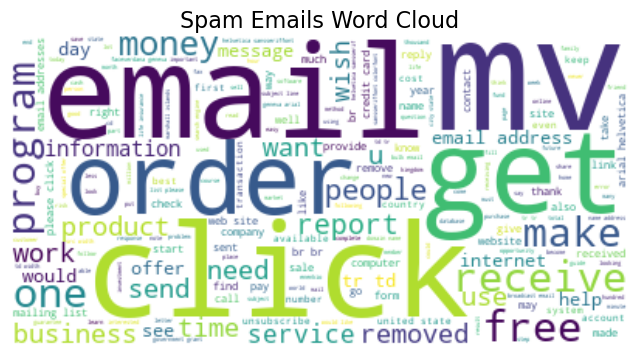

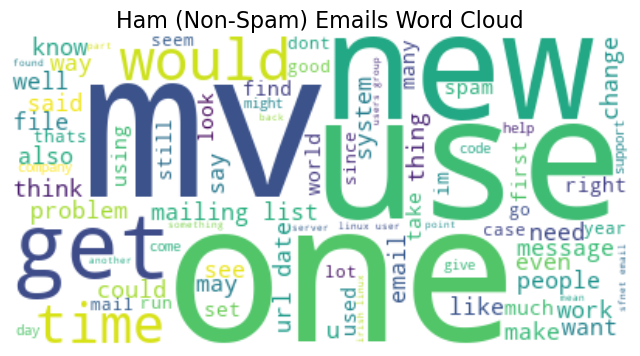

In [22]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Make sure NLTK stopwords are available
import nltk
nltk.download('stopwords')

# Separate spam and ham emails based on your dataset
spam_emails = raw_df[raw_df['Label'] == 1]  # Spam emails
ham_emails = raw_df[raw_df['Label'] == 0]   # Ham emails

# Concatenate all cleaned content for spam and ham
spam_text = " ".join(spam_emails['Cleaned_Content'].dropna())
ham_text = " ".join(ham_emails['Cleaned_Content'].dropna())

# Define a function to generate a word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(stopwords=set(stopwords.words('english')), background_color='white').generate(text)

    # Display the word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Generate word cloud for spam emails
generate_wordcloud(spam_text, "Spam Emails Word Cloud")

# Generate word cloud for ham (non-spam) emails
generate_wordcloud(ham_text, "Ham (Non-Spam) Emails Word Cloud")


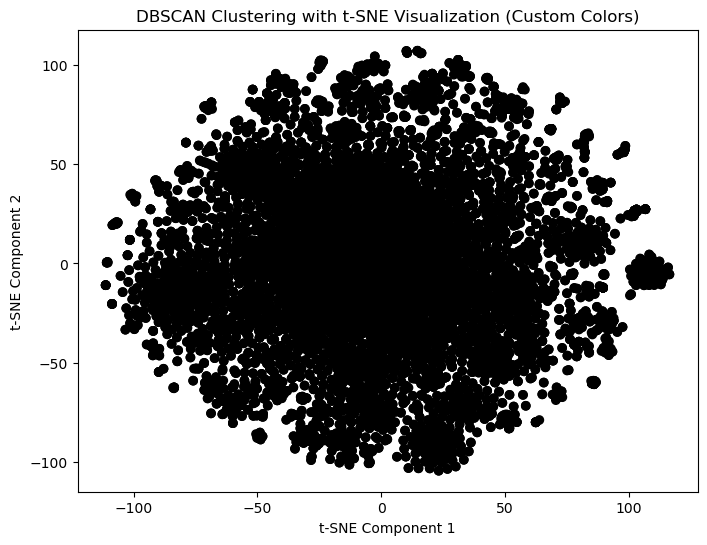

In [58]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import numpy as np

# Vectorization using TF-IDF on Lemmatized_Tokens
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(raw_df['Lemmatized_Tokens'].apply(lambda x: ' '.join(x)))

# DBSCAN
dbscan = DBSCAN(eps=100, min_samples=50)  # Using the same parameters as you mentioned
dbscan_labels = dbscan.fit_predict(X)

# tsne for visualization
tsne = TSNE(n_components=2, random_state=100)
X_tsne = tsne.fit_transform(X.toarray())

# color palette 
colors = ['black', 'brown', 'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'grey', 'pink']  # Extend this if needed
unique_labels = np.unique(dbscan_labels)
color_dict = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=[color_dict[label] for label in dbscan_labels], marker='o', edgecolor='k')
plt.title("DBSCAN Clustering with t-SNE Visualization (Custom Colors)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


Clustering with DBScan

In [59]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import numpy as np

# Vectorization using TF-IDF on Lemmatized_Tokens
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(raw_df['Lemmatized_Tokens'].apply(lambda x: ' '.join(x)))



C:\Users\bhand\AppData\Local\Temp\ipykernel_4564\4152936568.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(np.unique(dbscan_labels)))


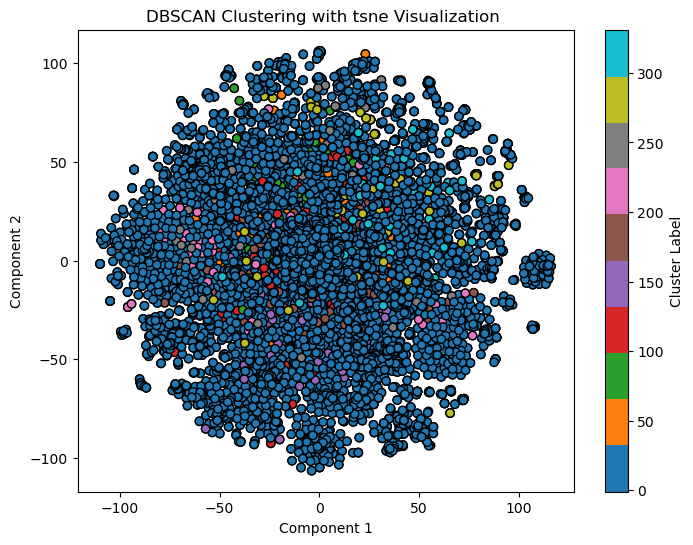

In [60]:

dbscan = DBSCAN(eps=1, min_samples=2)  # Using the parameters you mentioned
dbscan_labels = dbscan.fit_predict(X)

# tsne for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

#dynamic colormap based on the number of clusters
cmap = plt.cm.get_cmap('tab10', len(np.unique(dbscan_labels)))  

# Plot using the dynamic colormap
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap=cmap, marker='o', edgecolor='k')
plt.title("DBSCAN Clustering with tsne Visualization ")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# colorbar for reference
plt.colorbar(scatter, label='Cluster Label')
plt.show()


# Clustering with Kmeans with n =2

C:\Users\bhand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\bhand\AppData\Local\Temp\ipykernel_4564\1014733043.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)  # Using 'tab10' for color mapping


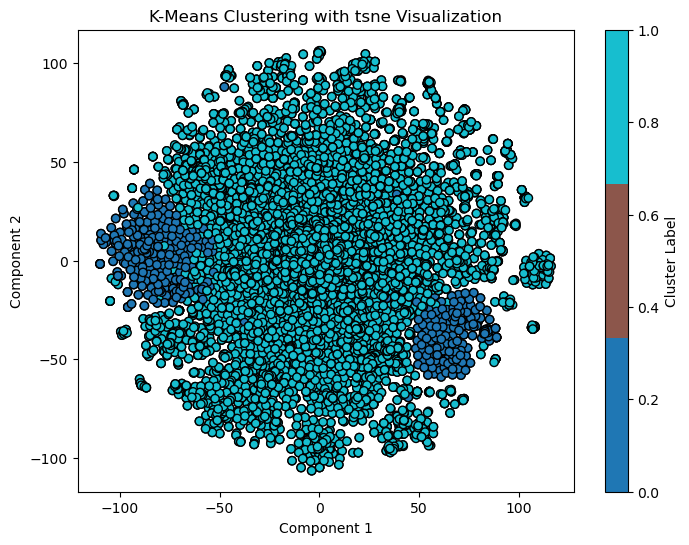

In [61]:
from sklearn.cluster import KMeans

# K-Means

kmeans = KMeans(n_clusters=2, random_state=100)
kmeans_labels = kmeans.fit_predict(X)

# tsne for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# colormap based on the number of clusters
cmap = plt.cm.get_cmap('tab10', n_clusters)  # Using 'tab10' for color mapping

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap=cmap, marker='o', edgecolor='k')
plt.title("K-Means Clustering with tsne Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Clustering with Kmeans with n =3

C:\Users\bhand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\bhand\AppData\Local\Temp\ipykernel_4564\3157054322.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)  # Using 'tab10' for color mapping


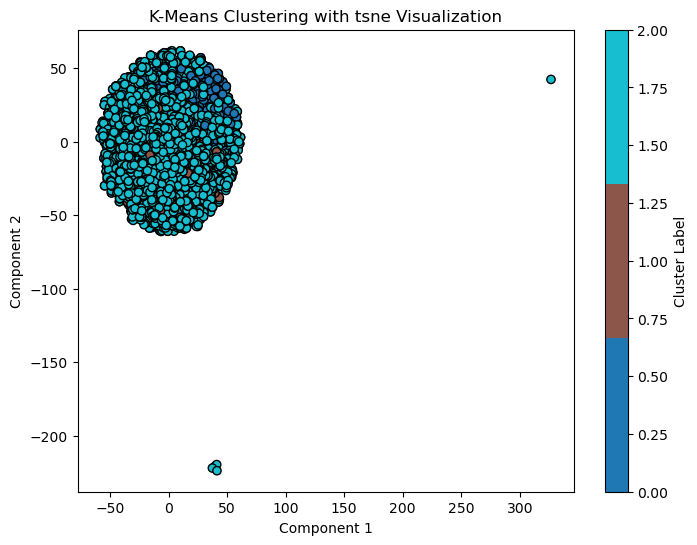

In [65]:
from sklearn.cluster import KMeans

# K-Means

kmeans = KMeans(n_clusters=3, random_state=100)
kmeans_labels = kmeans.fit_predict(X)

# tsne for visualization
tsne = TSNE(n_components=3, random_state=100)
X_tsne = tsne.fit_transform(X.toarray())

# cmap
cmap = plt.cm.get_cmap('tab10', n_clusters)  # Using 'tab10' for color mapping

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap=cmap, marker='o', edgecolor='k')
plt.title("K-Means Clustering with tsne Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Running it on Tokens instead of Lemmatized Tokens

In [66]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import numpy as np

# Vectorization using TF-IDF on Lemmatized_Tokens
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(raw_df['Tokens'].apply(lambda x: ' '.join(x)))

C:\Users\bhand\AppData\Local\Temp\ipykernel_4564\2343446266.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(np.unique(dbscan_labels)))


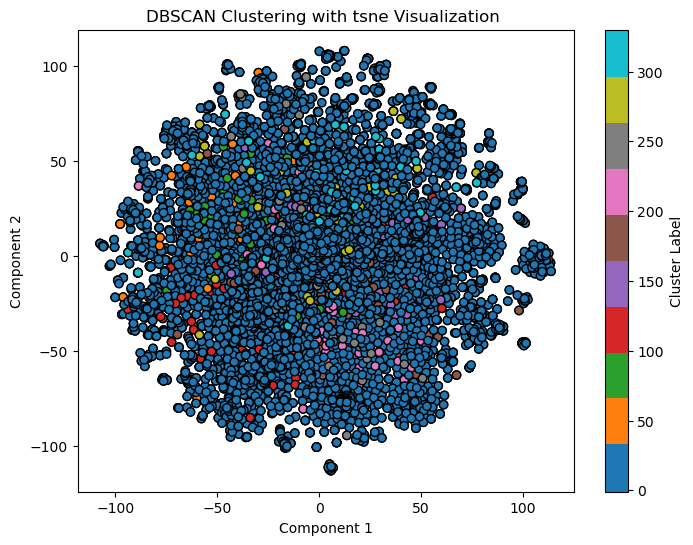

In [67]:
dbscan = DBSCAN(eps=1, min_samples=2)  # Using the parameters you mentioned
dbscan_labels = dbscan.fit_predict(X)

# tsne for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

#dynamic colormap based on the number of clusters
cmap = plt.cm.get_cmap('tab10', len(np.unique(dbscan_labels)))  

# Plot using the dynamic colormap
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap=cmap, marker='o', edgecolor='k')
plt.title("DBSCAN Clustering with tsne Visualization ")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# colorbar for reference
plt.colorbar(scatter, label='Cluster Label')
plt.show()

C:\Users\bhand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\bhand\AppData\Local\Temp\ipykernel_4564\2311544712.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)  # Using 'tab10' for color mapping


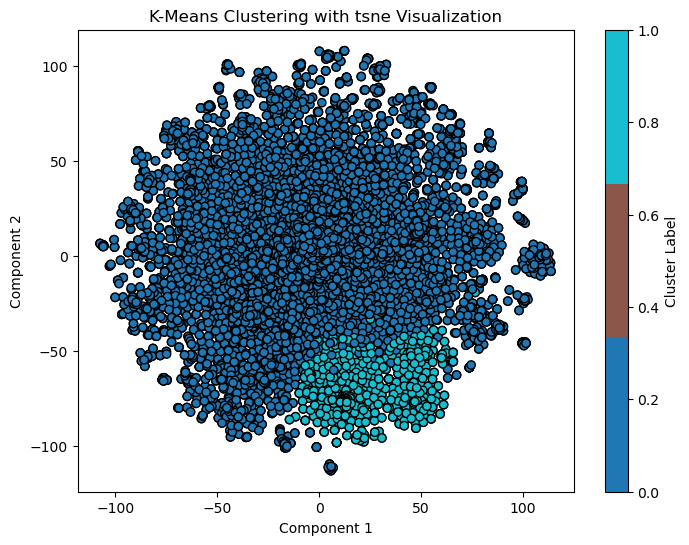

In [68]:
from sklearn.cluster import KMeans

# K-Means

kmeans = KMeans(n_clusters=2, random_state=100)
kmeans_labels = kmeans.fit_predict(X)

# tsne for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# colormap based on the number of clusters
cmap = plt.cm.get_cmap('tab10', n_clusters)  # Using 'tab10' for color mapping

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap=cmap, marker='o', edgecolor='k')
plt.title("K-Means Clustering with tsne Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.colorbar(scatter, label='Cluster Label')
plt.show()

C:\Users\bhand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\bhand\AppData\Local\Temp\ipykernel_4564\3157054322.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)  # Using 'tab10' for color mapping


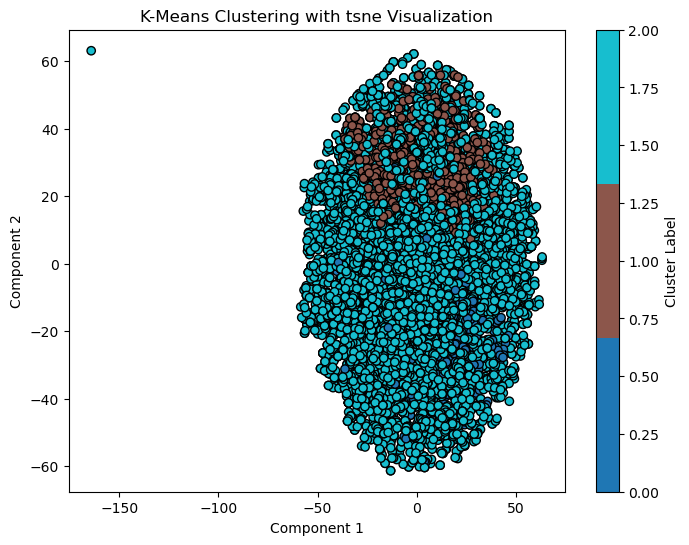

In [69]:
from sklearn.cluster import KMeans

# K-Means

kmeans = KMeans(n_clusters=3, random_state=100)
kmeans_labels = kmeans.fit_predict(X)

# tsne for visualization
tsne = TSNE(n_components=3, random_state=100)
X_tsne = tsne.fit_transform(X.toarray())

# cmap
cmap = plt.cm.get_cmap('tab10', n_clusters)  # Using 'tab10' for color mapping

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap=cmap, marker='o', edgecolor='k')
plt.title("K-Means Clustering with tsne Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.colorbar(scatter, label='Cluster Label')
plt.show()

# NB Classifier

In [70]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline



# Data preperation
X = raw_df['Cleaned_Content']  
y = raw_df['Label']  # 0 for ham, 1 for spam

#  TF-IDF Vectorizer and Naive Bayes Classifier pipeline
model = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())

#  Cross-Validation

cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print the results
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Accuracy: {cross_val_scores.mean():.4f}")



Cross-Validation Accuracy Scores: [0.93800107 0.94441475 0.90646713 0.90909091 0.93475936]
Mean Accuracy: 0.9265
Standard Deviation of Accuracy: 0.0157


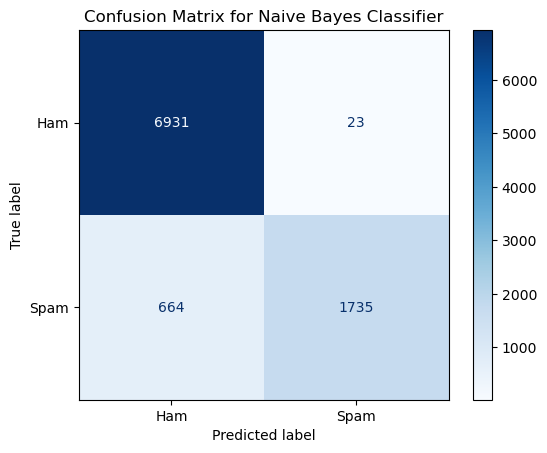

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

X_cleaned_content = raw_df['Cleaned_Content']
#cross-validation and  predictions
y_pred = cross_val_predict(model, X_cleaned_content, y, cv=5)

# Generate confusion matrix
cm = confusion_matrix(y, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()


In [73]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# recision, recall
precision = cross_val_score(model, X_cleaned_content, y, cv=5, scoring=make_scorer(precision_score))
recall = cross_val_score(model, X_cleaned_content, y, cv=5, scoring=make_scorer(recall_score))


print(f"Mean Precision: {precision.mean():.4f}")
print(f"Mean Recall: {recall.mean():.4f}")



Mean Precision: 0.9886
Mean Recall: 0.7232


In [78]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_prob = cross_val_predict(model, X_cleaned_content, y, cv=5, method='predict_proba')

# Adjust the threshold 
threshold = 0.20  
y_pred_adjusted = (y_prob[:, 1] >= threshold).astype(int)

# Evaluate precision and recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y, y_pred_adjusted)
recall = recall_score(y, y_pred_adjusted)

print(f"Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")


Precision: 0.9641
 Recall: 0.9079


# Adjusted NB model at 0.2 threshold

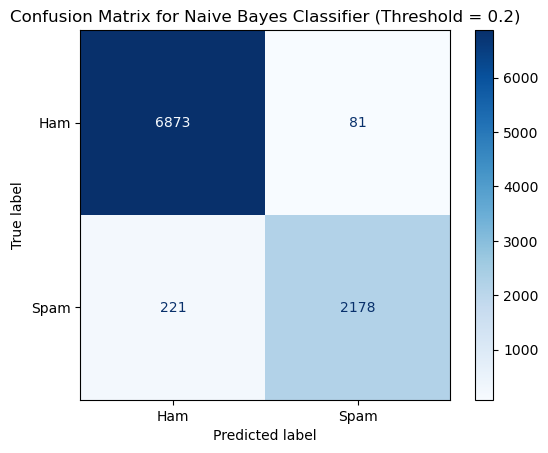

Precision (Threshold = 0.2): 0.9641
Recall (Threshold = 0.2): 0.9079
Accuracy (Threshold = 0.2): 0.9677


In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_predict

#  cross-validation
y_prob = cross_val_predict(model, X_cleaned_content, y, cv=5, method='predict_proba')

#  0.2 threshold
threshold = 0.2
y_pred_adjusted = (y_prob[:, 1] >= threshold).astype(int)

# display the confusion matrix
cm_adjusted = confusion_matrix(y, y_pred_adjusted, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix for Naive Bayes Classifier (Threshold = {threshold})")
plt.show()

#  Precision, Recall, and Accuracy 
precision = precision_score(y, y_pred_adjusted)
recall = recall_score(y, y_pred_adjusted)
accuracy = accuracy_score(y, y_pred_adjusted)

print(f"Precision (Threshold = {threshold}): {precision:.4f}")
print(f"Recall (Threshold = {threshold}): {recall:.4f}")
print(f"Accuracy (Threshold = {threshold}): {accuracy:.4f}")


## Reference Code:

https://github.com/edricgsh/Email-Spam-Detection-Python/blob/master/Email%20Spamming%20(Medium%20Part%201).ipynb

chatgpt